###Reading the Dataset

In [0]:
%pip install gdown

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%sh
gdown 1fH1V1SLB-GXsktREDo7JIkndV0DHKC73
ls -l

Downloading...
From: https://drive.google.com/uc?id=1fH1V1SLB-GXsktREDo7JIkndV0DHKC73
To: /databricks/driver/data.csv

  0%|          | 0.00/10.0M [00:00<?, ?B/s]
 89%|████████▉ | 8.91M/10.0M [00:00<00:00, 85.0MB/s]
100%|██████████| 10.0M/10.0M [00:00<00:00, 90.6MB/s]
total 11084
drwxr-xr-x 2 root root     4096 Jan  1  1970 azure
drwxr-xr-x 2 root root     4096 Dec 12 02:28 conf
-rw-r--r-- 1 root root 10008604 Dec 12 02:39 data.csv
-rw-r--r-- 1 root root      705 Dec 12 02:33 derby.log
drwxr-xr-x 3 root root     4096 Dec 12 02:33 eventlogs
-r-xr-xr-x 1 root root     3037 Jan  1  1970 hadoop_accessed_config.lst
drwxr-xr-x 2 root root     4096 Dec 12 02:33 logs
drwxr-xr-x 5 root root     4096 Dec 12 02:33 metastore_db
-r-xr-xr-x 1 root root  1307279 Jan  1  1970 preload_class.lst


In [0]:
# If running on DataBricks, Please Install Spark NLP by going to 
#Cluster>Libraries>Install New>PyPI>spark-nlp==4.2.4
#AND
#Cluster>Libraries>Maven>Search Packages>Maven Central>com.johnsnowlabs.nlp:spark-nlp_2.12:4.2.4

In [0]:
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd
from pyspark.ml import Model
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.sql.functions import col
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import re

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)


Spark NLP version 4.2.4
Apache Spark version: 3.3.0


In [0]:
data = spark.read.csv('file:/databricks/driver/data.csv', inferSchema=True, header=True, mode='DROPMALFORMED')
display(data)

index title genre summary 4 Taran Wanderer fantasy Taran and Gurgi have returned to Caer Dallben following the events of the third chronicle, The Castle of Llyr. It is now full springtime, at least three years after The Book of Three. Taran knows that he loves Princess Eilonwy, who now resides at Dinas Rhydnant for royal education. In full springtime some weeks after return from escorting her there, he is restless and determines to know his parentage, noble or common, partly in hopes that noble birth will support a marriage proposal. Dallben the enchanter tells him nothing but gives his approval for Taran and Gurgi to travel on their own. They travel first to the Marshes of Morva to ask the witches Orddu, Orwen and Orgoch. Taran has nothing of great value to give in exchange, so Orddu merely tells him of an alternative, the Mirror of Llunet in the far east Llawgadarn Mountains will show him who he is. Taran goes next to Cantrev Cadiffor to be outfit by King Smoit for a longer journey. After a border patrol of Smoit's vassal Lord Goryon steals his horse Melynlas and Gurgi's pony, they spend the night with the farm couple Aeddan and Alarca who have lost their son and livestock. Taran would be welcome to remain and he leaves with new respect for common farmers. They recover their steeds because Melynlas will have no other rider and Goryon is relieved to escape the honorary burden of mastering him.At the neighboring stronghold of Lord Gast they meet old friend Fflewddur Fflam, who seems to return to wandering as a bard every spring. Together they go on to Caer Cadarn where Smoit does welcome them. Goryon and Gast have been feuding for years (every spring?), especially over the prize cow Cornillo. When their dispute breaks out again next day, Taran questions King Smoit's habitual resort to imprisonment and persuades Smoit to try Taran's judgment. Namely, the rival cantrev lords shall resow the fields of Aeddan, which have been ruined by battles. The prize cow shall be further compensation, although the lords shall have her calves. The remainder of their commingled herds shall be divided in half by Goryon, and Gast will choose which half to take for himself. The childless widower Smoit later offers to adopt Taran as his son, who will succeed as King of Cadiffor. Taran declines but says he will gladly accept if he discovers noble birth. Continuing eastward, they cross Ystrad. Taran's pet crow Kaw and Fflewddur's mount Llyan, a giant lion, find treasures which they bring to their masters. Kaw a polished bone the size of a toothpick, which has been stashed high in a tree. Llyan a green and yellow frog that has nearly dried to death: their old friend Doli the dwarf, whom they revive. Doli has been transformed during investigation of a deadly threat to the Fair Folk. He knows that he is not the first to disappear in animal form, for a human wizard Morda has attained power to enchant them, and to raid their underground realms. Taran and Gurgi investigate Morda's abode, followed by Fflewddur, but all are captured by his snares. After explaining himself (history, boasts, plans), Morda turns Fflewddur and Gurgi into a hare and a mouse, but fails to transform Taran. Something protects him, and he guesses from the stump of Morda's little finger that it is the polished bone. Although elderly, Morda is stronger than Taran, but his strength finally snaps the bone in desperate fury to regain it. (Morda has worn a silver crescent moon with pendant jewel on a necklace. Eilonwy has one without the jewel, and Morda prompted by Taran's recognition of the symbol of the House of Llyr has revealed the primary source of his magic. After Eilonwy was kidnapped as a child, the long search by her mother Angharad ended here, where she weakly sought shelter. Morda inherited both the amulet she wore and the empty book among her possessions. He mastered the amulet and developed its power, gave the book to a pest Glew. (The Castle of Llyr.) Morda's death restores D

### Exploratory Data Analysis

In [0]:
data.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+-----+
|               genre|count|
+--------------------+-----+
|                null| 1853|
|            thriller| 1023|
|             fantasy|  876|
|             science|  646|
|             history|  600|
|              horror|  600|
|               crime|  500|
|             romance|  111|
|              travel|  100|
|          psychology|  100|
|              sports|  100|
|             however|    6|
|              though|    5|
|                 too|    4|
| these ""shining ...|    3|
| the popular new ...|    3|
| and their awe-in...|    3|
|           after all|    3|
|                 and|    3|
| regards it as a ...|    3|
+--------------------+-----+
only showing top 20 rows



From above cell we can see there are many bla bla categories, so removing all of them.

In [0]:
data = data.filter((data.genre=='thriller') | (data.genre=='fantasy') | (data.genre=='science') | (data.genre=='history') | (data.genre=='horror') | (data.genre=='crime'))
data.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|   genre|count|
+--------+-----+
|thriller| 1023|
| fantasy|  876|
| science|  646|
|  horror|  600|
| history|  600|
|   crime|  500|
+--------+-----+



In [0]:
df_countgenre=data.groupBy("genre") \
    .count() \
    .orderBy(col("count").desc())


In [0]:
display(df_countgenre)

genre,count
thriller,1023
fantasy,876
science,646
horror,600
history,600
crime,500


Output can only be rendered in Databricks

Output can only be rendered in Databricks

### Data Preprocessing

In [0]:
# Clean description using regular-expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="summary", outputCol="words", pattern="\\W")

# exclue stop words
add_stopwords = ["a","an","the","of","at"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)

# bag-of-words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

# StringIndexer
label_stringIdx = StringIndexer(inputCol = "genre", outputCol = "label")

In [0]:
# Put everything in pipeline (We use regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx)
# you can use hasingTF and IDF alternatively than countVectors
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
dataset.show(5)

+-----+--------------------+-------+--------------------+--------------------+--------------------+--------------------+-----+
|index|               title|  genre|             summary|               words|            filtered|            features|label|
+-----+--------------------+-------+--------------------+--------------------+--------------------+--------------------+-----+
|    4|      Taran Wanderer|fantasy| Taran and Gurgi ...|[taran, and, gurg...|[taran, and, gurg...|(7429,[0,1,2,3,4,...|  1.0|
|    5|      Thendara House|fantasy| The novel concer...|[the, novel, conc...|[novel, concerns,...|(7429,[0,2,11,14,...|  1.0|
|    6|           The Thief|fantasy| Gen is released ...|[gen, is, release...|[gen, is, release...|(7429,[0,1,2,3,5,...|  1.0|
|    7| The Sweet Far Thing|fantasy| The prologue beg...|[the, prologue, b...|[prologue, begins...|(7429,[0,1,2,3,4,...|  1.0|
|    8|Mistborn: The Fin...|fantasy| In Luthadel, the...|[in, luthadel, th...|[in, luthadel, ca...|(7429,[0,1,2

In [0]:
# Split Train/Test data
(trainingData, testData) = dataset.randomSplit([0.75, 0.25], seed = 623)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 2139
Test Dataset Count: 742


### Data Modelling And Evaluation

#### Logistic Regression Modelling

In [0]:
# We use Logistic-Regression model
lr = LogisticRegression()
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("summary","genre","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                       summary|   genre|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
|Her eyes are wide open. Her...|thriller|[1.0,1.0381558817361011E-16...|  0.0|       0.0|
|She was born with her eyes ...| fantasy|[1.0,7.858430735314544E-17,...|  1.0|       0.0|
|Could ten days at a health ...|thriller|[1.0,6.715761700223973E-17,...|  0.0|       0.0|
| The city of Phlan has vani...| fantasy|[1.0,2.762301943196736E-22,...|  1.0|       0.0|
|Under the streets of London...| fantasy|[1.0,4.03057066911804E-23,3...|  1.0|       0.0|
|Manchmal ist es ein echtes ...| fantasy|[1.0,3.2375932126687682E-24...|  1.0|       0.0|
| A mugger is attacking wome...|   crime|[1.0,8.468557309834561E-26,...|  4.0|       0.0|
| The story begins with Bob ...|thriller|[1.0,2.921124167875045E-27,...|  0.0|       0.0|
|Where wer

##### Logistic Regression Accuracy

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
LrAccuracy = evaluator.evaluate(predictions)
print("Logistic Regression Accuracy is : ", LrAccuracy) 

Logistic Regression Accuracy is :  0.5754358769394988


#### Decision Tree Classifier Modelling

In [0]:
tree = DecisionTreeClassifier()
tree_model = tree.fit(trainingData)
prediction = tree_model.transform(testData)
prediction.select('label', 'prediction', 'probability').show(n = 5, truncate = 30)


+-----+----------+------------------------------+
|label|prediction|                   probability|
+-----+----------+------------------------------+
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       0.0|[0.34296028880866425,0.2151...|
|  4.0|       4.0|[0.24468085106382978,0.0425...|
+-----+----------+------------------------------+
only showing top 5 rows



##### Decision Tree Classifier Accuracy

In [0]:
prediction.groupBy('label', 'prediction').count().show(n = 5, truncate = 30)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
DtAccuracy = evaluator.evaluate(predictions)
print("Accuracy for Decision Tree Classifier is: ",DtAccuracy)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   50|
|  3.0|       5.0|    1|
|  1.0|       1.0|   19|
|  3.0|       2.0|   15|
|  4.0|       2.0|   18|
+-----+----------+-----+
only showing top 5 rows

Accuracy for Decision Tree Classifier is:  0.5754358769394988


#### NaiveBayes Modelling

In [0]:
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("summary","genre","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 5, truncate = 30)

+------------------------------+--------+------------------------------+-----+----------+
|                       summary|   genre|                   probability|label|prediction|
+------------------------------+--------+------------------------------+-----+----------+
| A plane crashes over the A...|thriller|[1.0,3.43860343721215E-31,4...|  0.0|       0.0|
| Set in the town of Bolton,...|thriller|[1.0,1.8021776540582083E-33...|  0.0|       0.0|
| It is 1944. A message from...|  horror|[1.0,8.269282901970913E-41,...|  5.0|       0.0|
| The book begins with James...|thriller|[1.0,1.2789387407877632E-53...|  0.0|       0.0|
| In January 1954 a United S...|thriller|[1.0,2.075755428624546E-63,...|  0.0|       0.0|
+------------------------------+--------+------------------------------+-----+----------+
only showing top 5 rows



##### NaiveBayes Accuracy

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
NbAccuracy = evaluator.evaluate(predictions)
print("Accuracy for NaiveBayes is: ",NbAccuracy)

Accuracy for NaiveBayes is:  0.6470495521740277


#### Cross Validation

In [0]:
# Pipeline basic to be shared across model fitting and testing
pipeline = Pipeline(stages=[])  # Must initialize with empty list!

# base pipeline (the processing here should be reused across pipelines)
basePipeline =[]

#############################################################
# Specify Logistic Regression model
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

pl_lr = basePipeline + [lr]
pg_lr = ParamGridBuilder()\
          .baseOn({pipeline.stages: pl_lr})\
          .addGrid(lr.regParam,[0.1, .4])\
          .build()
#############################################################
# Specify Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="label",featuresCol= "features")
pl_dt = basePipeline + [dt]
pg_dt = ParamGridBuilder()\
      .baseOn({pipeline.stages: pl_dt})\
      .addGrid(dt.maxDepth, [2, 5, 8])\
      .addGrid(dt.maxBins, [10, 15, 20])\
      .build()

#############################################################
# Naive Bayes Tree model
nb = NaiveBayes(smoothing=1)
pl_nb = basePipeline + [nb]
pg_nb = ParamGridBuilder()\
      .baseOn({pipeline.stages: pl_nb})\
      .build()

# One grid from the individual grids
paramGrid = pg_lr + pg_dt + pg_nb


In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [0]:
cv = CrossValidator()\
      .setEstimator(pipeline)\
      .setEvaluator(evaluator)\
      .setEstimatorParamMaps(paramGrid)\
      .setNumFolds(2)

cvModel = cv.fit(trainingData)

##### Cross Validation Results

In [0]:
print("Best Model")
print(cvModel.getEstimatorParamMaps()[ np.argmax(cvModel.avgMetrics) ])
print("Worst Model")
print (cvModel.getEstimatorParamMaps()[ np.argmin(cvModel.avgMetrics) ])

Best Model
{Param(parent='Pipeline_4db16525bb4c', name='stages', doc='a list of pipeline stages'): [NaiveBayes_317c811bb986]}
Worst Model
{Param(parent='Pipeline_4db16525bb4c', name='stages', doc='a list of pipeline stages'): [DecisionTreeClassifier_e6089b8b8847], Param(parent='DecisionTreeClassifier_e6089b8b8847', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 2, Param(parent='DecisionTreeClassifier_e6089b8b8847', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 10}


In [0]:

def paramGrid_model_name(model):
    params = [v for v in model.values() if type(v) is not list]
    name = [v[-1] for v in model.values() if type(v) is list][0]
    name = re.match(r'([a-zA-Z]*)', str(name)).groups()[0]
    return "{}{}".format(name,params)

# Resulting metric and model description
# get the measure from the CrossValidator, cvModel.avgMetrics
# get the model name & params from the paramGrid
# put them together here:
measures = zip(cvModel.avgMetrics, [paramGrid_model_name(m) for m in paramGrid])
metrics,model_names = zip(*measures)

<Figure size 432x288 with 0 Axes>

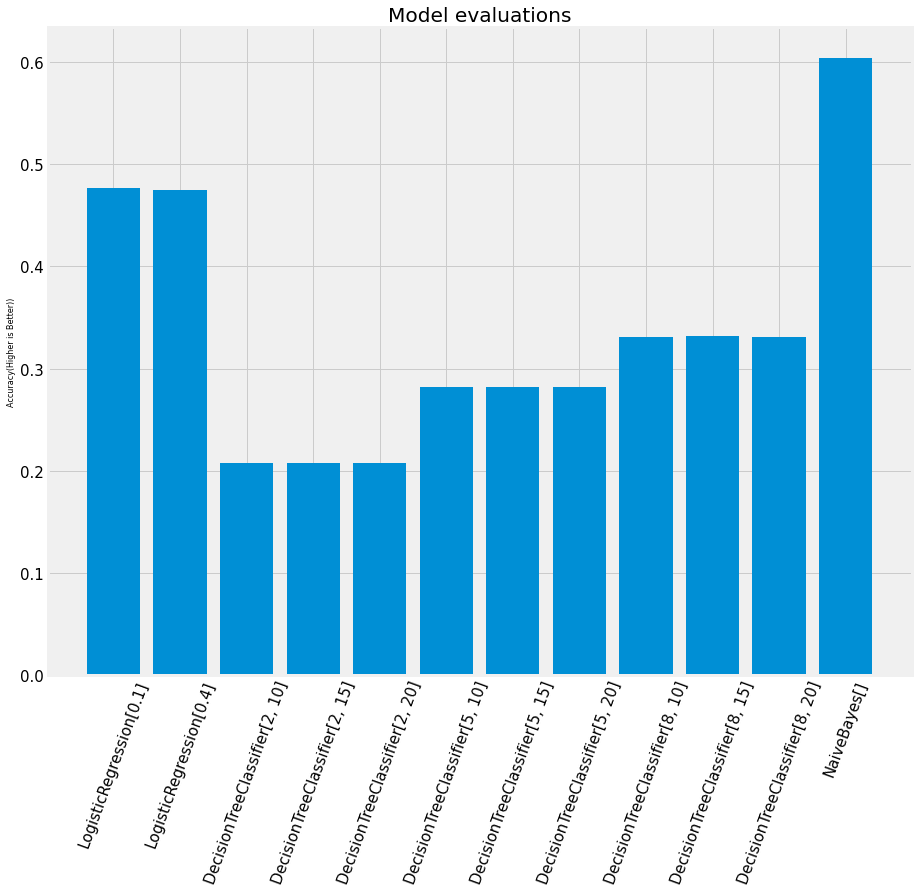

In [0]:
plt.clf() # clear figure
fig = plt.figure( figsize=(15, 15))
plt.style.use('fivethirtyeight')
axis = fig.add_axes([0.1, 0.3, 0.8, 0.6])
# plot the metrics as Y
#plt.plot(range(len(model_names)),metrics)
plt.bar(range(len(model_names)),metrics)
# plot the model name & param as X labels
plt.xticks(range(len(model_names)), model_names, rotation=70, fontsize=15)
plt.yticks(fontsize=15)
#plt.xlabel('model',fontsize=8)
plt.ylabel('Accuracy(Higher is Better))',fontsize=8)
plt.title('Model evaluations')
display(plt.show())

In [0]:
list(metrics)

Out[24]: [0.4763571831320177,
 0.4743362596181957,
 0.20776066652625697,
 0.20776066652625697,
 0.20776066652625697,
 0.28153838519432894,
 0.2822844335327904,
 0.28153838519432894,
 0.3313410069640008,
 0.3321887459914721,
 0.33136496000194127,
 0.6036891684520624]

#### SPARK NLP

##### Universal Sentence Encoder

In [0]:
document = DocumentAssembler()\
    .setInputCol("summary")\
    .setOutputCol("document")
    
# we can also use sentence detector here 
# if we want to train on and get predictions for each sentence
# downloading pretrained embeddings
use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")
# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("genre")\
  .setMaxEpochs(10)\
  .setLr(0.001)\
  .setBatchSize(40)\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)
use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [0]:
use_pipelineModel = use_clf_pipeline.fit(trainingData)

In [0]:
preds = use_pipelineModel.transform(testData)

###### Accuracy

In [0]:
preds_df = preds.select('genre','summary',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])
print (classification_report(preds_df['genre'], preds_df['result']))
UniversalAccuracy = accuracy_score(preds_df['genre'],preds_df['result'])
print("Accuracy with Universal Sentence Encoder is: ",UniversalAccuracy)

              precision    recall  f1-score   support

       crime       0.00      0.00      0.00        88
     fantasy       0.39      0.88      0.54       161
     history       0.00      0.00      0.00       106
      horror       0.00      0.00      0.00        87
     science       0.00      0.00      0.00        96
    thriller       0.45      0.84      0.58       204

    accuracy                           0.42       742
   macro avg       0.14      0.29      0.19       742
weighted avg       0.21      0.42      0.28       742

Accuracy with Universal Sentence Encoder is:  0.42183288409703507
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classifi

In [0]:
preds_df.head()

,genre,summary,result
0,crime,"The novel's central character is Joe Cashin, ...",thriller
1,crime,"While staying with his Aunt Jane in Suffolk, ...",thriller
2,crime,The book's plot concerns the murder of Ulysse...,thriller
3,crime,The story begins with Tetsuya Ishigami and Ya...,fantasy
4,crime,When the esteemed flautist Sir Manuel Camargu...,fantasy


##### Bert embedding

In [0]:
document_assembler = DocumentAssembler() \
                .setInputCol("summary") \
                .setOutputCol("document")

tokenizer = Tokenizer() \
                .setInputCols(["document"]) \
                .setOutputCol("token")
      
bert_embeddings = BertEmbeddings().pretrained(name='small_bert_L4_256', lang='en') \
                .setInputCols(["document",'token'])\
                .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
                .setInputCols(["document", "embeddings"]) \
                .setOutputCol("sentence_embeddings") \
                .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
                .setInputCols(["sentence_embeddings"])\
                .setOutputCol("class")\
                .setLabelColumn("genre")\
                .setMaxEpochs(40)\
                .setLr(0.001)\
                .setBatchSize(20)\
                .setEnableOutputLogs(True)
                #.setOutputLogsPath('logs')

bert_clf_pipeline = Pipeline(stages=[document_assembler,
                                     tokenizer,
                                     bert_embeddings,
                                     embeddingsSentence,
                                     classsifierdl])

small_bert_L4_256 download started this may take some time.
Approximate size to download 40.5 MB
[OK!]


In [0]:
bert_clf_pipelineModel = bert_clf_pipeline.fit(trainingData)

In [0]:
preds = bert_clf_pipelineModel.transform(testData)

###### Accuracy

In [0]:
preds_df = preds.select('genre','summary',"class.result").toPandas()
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])
print (classification_report(preds_df['genre'], preds_df['result']))
BertAccuracy = accuracy_score(preds_df['genre'],preds_df['result'])
print("Accuracy with Bert Embedding is: ",BertAccuracy)

              precision    recall  f1-score   support

       crime       0.00      0.00      0.00        88
     fantasy       0.48      0.78      0.60       161
     history       0.64      0.63      0.64       106
      horror       0.00      0.00      0.00        87
     science       0.00      0.00      0.00        96
    thriller       0.43      0.81      0.57       204

    accuracy                           0.48       742
   macro avg       0.26      0.37      0.30       742
weighted avg       0.32      0.48      0.38       742

Accuracy with Bert Embedding is:  0.4811320754716981
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:124

### Summary And Evaluation

In [0]:
###Creating a comparision of models 

models = list(model_names) + ["Classifier DL with BERT embedding","Classifier DL with Universal embedding"]
Accuracies = list(metrics) + [BertAccuracy , UniversalAccuracy]
result = pd.DataFrame(list(zip(Accuracies, models)),
               columns =['Accuracies', 'models'])
display(result)

Accuracies,models
0.4763571831320177,LogisticRegression[0.1]
0.4743362596181957,LogisticRegression[0.4]
0.20776066652625697,"DecisionTreeClassifier[2, 10]"
0.20776066652625697,"DecisionTreeClassifier[2, 15]"
0.20776066652625697,"DecisionTreeClassifier[2, 20]"
0.28153838519432894,"DecisionTreeClassifier[5, 10]"
0.2822844335327904,"DecisionTreeClassifier[5, 15]"
0.28153838519432894,"DecisionTreeClassifier[5, 20]"
0.3313410069640008,"DecisionTreeClassifier[8, 10]"
0.3321887459914721,"DecisionTreeClassifier[8, 15]"


Output can only be rendered in Databricks

Performance Evaluation
1. We tried multiple models, such as basic models and spark nlp models
2. We used cross validator to check the performance of all out of which Naive bayes performed the best
3. From Spark NLP we used classifier DL model with Universal and Bert Embeddings.
4. We believe that less data samples could be the major reason for low performance.

Learnings
1. We learned to work with text embeddings. 
2. We also got a chance to work with spark nlp models
3. Our solution dealt with multiclass classification

references
https://github.com/hyunjoonbok/PySpark/blob/master/Multi-class%20Text%20Classification%20Problem%20with%20PySpark%20and%20MLlib.ipynb